Analysis of SGD's learning rate has shown that our rule of thumb fails when learning rates are too high.  

In this notebook, we inspect those badly behaving layer rotation curves further and show that they contain training updates that perform extremely large rotations of the layer's weights that do not improve training accuracy.

In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.insert(0, "../")

import warnings
import os
import time

import math as m
import numpy as np
np.random.seed(1)

import matplotlib
import matplotlib.pyplot as plt
import pickle

from experiment_utils import history_todict, get_val_split, History_batch
from layca_optimizers import SGD
from layer_rotation_utils import LayerRotationCurves, plot_layer_rotation_curves

from import_task import import_task
from get_training_utils import get_training_schedule, get_optimized_training_schedule, get_stopping_criteria, get_optimizer, get_learning_rate_multipliers

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
# utilities for storing the results in pickle files
result_file = 'results_lr_analysis.p'
def load_results():
    if not os.path.isfile(result_file):
        return {}
    else:
        with open(result_file,'rb') as f:
            return pickle.load(f)

def dump_results(results):
    with open(result_file,'wb') as f:
        pickle.dump(dict(results),f)

def update_results(path, new_data):
    results = load_results()
    position = results
    for p in path:
        position = position[p]
    # new_data is a dictionary with the new (key,value) pairs
    position.update(new_data)
    dump_results(results)

In [4]:
# if results should be saved in the file or not
save_results = True
if not save_results:
    results = {}
# file for monitoring the experiment's progress
monitor_file = 'monitor_lr_analysis.txt' 

In [34]:
tasks = ['C10-CNN2','C100-WRN']#['C10-CNN1','C100-resnet','tiny-CNN','C10-CNN2','C100-WRN']
optimizers = ['SGD']
lrs = [3.**0]

for task in tasks:
    x_train, y_train, x_test, y_test, get_model = import_task(task)
    
    # validation set is needed for early stopping or learning rate/alpha selection
    [x_train, y_train], [x_val, y_val] = get_val_split(x_train,y_train, 0.1)
    
    # creates empty dictionary if first time the task is seen
    if save_results:
        results = load_results()
        if task not in results.keys():
            update_results([],{task:{}})
    elif task not in results.keys():
        results.update({task:{}})
    
    for optimizer in optimizers:        
        if save_results:
            results = load_results()
            if optimizer not in results[task].keys():
                update_results([task],{optimizer:{}}) 
        elif optimizer not in results[task].keys():
            results[task].update({optimizer:{}})

        for lr in lrs:
            start = time.time()
            model = get_model(weight_decay = 0.) if 'weight_decay' not in optimizer else get_model()

            batch_size = 128
            if lr == 'opt':
                epochs, lr, lr_scheduler = get_optimized_training_schedule(task,optimizer)
            else:
                epochs, lr_scheduler = get_training_schedule(task,lr)
            stop_callback = get_stopping_criteria(task)
            verbose = 0
            epochs = 1

            # frequency at which cosine distance from initialization is computed
            batch_frequency = 1
            ladc = LayerRotationCurves(batch_frequency = batch_frequency)
            history_batch = History_batch()

            callbacks = [lr_scheduler, ladc, history_batch]+ stop_callback

            multipliers = get_learning_rate_multipliers(model,alpha = 0.)
            # C100-WRN + SGD is the only case where nesterov momentum is used (cfr. original implementation)
            if task == 'C100-WRN' and optimizer in ['SGD','SGD_weight_decay']: 
                opt = SGD(lr=lr, momentum=0.9, nesterov=True,multipliers = multipliers)
            else:
                opt = get_optimizer(optimizer, lr,multipliers)
            metrics = ['accuracy', 'top_k_categorical_accuracy'] if 'tiny' in task else ['accuracy']
            model.compile(loss='categorical_crossentropy',
                          optimizer= opt,
                          metrics=metrics)

            with warnings.catch_warnings():
                if task in ['C10-CNN2','C100-WRN']:
                    # data augmentation
                    datagen = ImageDataGenerator(width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='reflect',
                             horizontal_flip=True)

                    warnings.simplefilter("ignore") # removes warning from keras for slow callback
                    history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                                  epochs = epochs,
                                                  verbose = verbose,
                                                  validation_data = (x_val, y_val),
                                                  callbacks = callbacks)
                else:
                    warnings.simplefilter("ignore") # removes warning from keras for slow callback
                    history = model.fit(x_train,y_train,
                                        epochs = epochs,
                                        batch_size = batch_size,
                                        verbose = verbose,
                                        validation_data = (x_val, y_val),
                                        callbacks = callbacks)


            if save_results:
                update_results([task, optimizer],{lr:{'history':history_todict(history),'ladc':ladc.memory,
                                                      'history_batch':history_todict(history_batch)}})
            else:
                results[task][optimizer].update({lr:{'history':history_todict(history),'ladc':ladc.memory,
                                                     'history_batch':history_todict(history_batch)}})

            with open(monitor_file,'a') as file:
                file.write(task + ', '+optimizer+', '+str(lr)+': done in '+str(time.time()-start)+' seconds.\n')

# Analysis of the results

In [5]:
results = load_results()

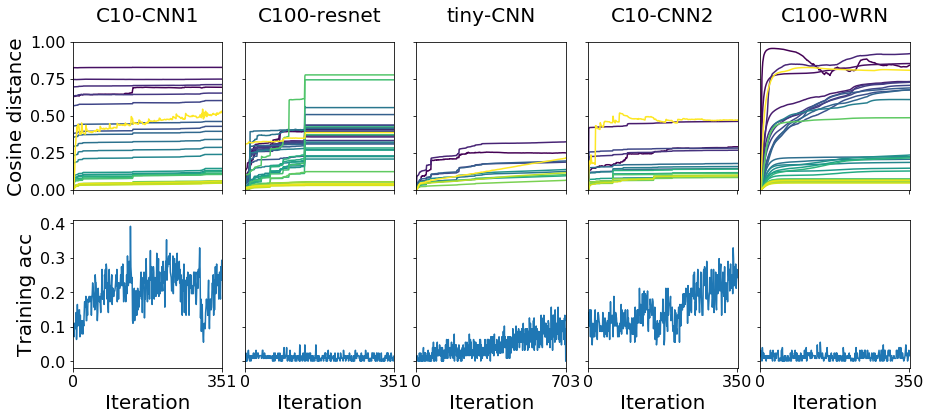

In [6]:
mpld3.disable_notebook()
matplotlib.rcParams.update({'font.size': 16})
tasks = ['C10-CNN1','C100-resnet','tiny-CNN', 'C10-CNN2', 'C100-WRN']

f, axes = plt.subplots(2,len(tasks), figsize = (3*len(tasks),6), sharex = 'col', sharey = 'row')
for j,task in enumerate(tasks):
    data = results[task]['SGD'][3.**0]
    
    plot_layer_rotation_curves(data['ladc'],axes[0,j])
    axes[0,j].set_xlabel('')
    if j>0:
        axes[0,j].set_ylabel('')
    else:
        axes[0,j].set_ylabel('Cosine distance',fontsize=20)
    
    axes[1,j].plot(data['history_batch']['batch'], data['history_batch']['history']['acc'])
    if j==0:
        axes[1,j].set_ylabel('Training acc',fontsize=20)
        axes[1,j].set_yticks([0,0.1,0.2,0.3,0.4])
    axes[1,j].set_xlabel('Iteration',fontsize=20)
    axes[1,j].set_xticks([0,max(data['history_batch']['batch'])])

    pad = 20
    size = 20
    axes[0,j].annotate(task, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=size, ha='center', va='baseline')

plt.subplots_adjust(hspace=0.2,wspace=0.15)
plt.savefig('figures/lr_further_analysis.png',format='png', dpi=200, bbox_inches="tight")